In [1]:
import torch # 파이토치
import random
import pandas as pd
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
import timm

/home/yumin/miniconda3/envs/detec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
raw_data = pd.read_csv("./dataset/sign_mnist_train.csv")
test_data = pd.read_csv("./dataset/sign_mnist_test.csv")
# raw_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/classification/data/sign_mnist_train.csv")

In [4]:
raw_data = raw_data[:2000]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

labels = raw_data.iloc[:, 0]
features = raw_data

val_data = pd.DataFrame()
train_data = pd.DataFrame()

for i, (_, label_index) in enumerate( kfold.split(features, labels)):
    pic_fold_data = features.iloc[label_index]

    if not i:
        val_data = pic_fold_data.reset_index(drop=True)
        
    else:
        train_data = pd.concat([train_data, pic_fold_data], ignore_index=True)

In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
1,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
2,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
3,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
4,10,0,25,38,40,41,46,50,56,69,...,129,85,60,64,72,70,67,65,62,64


In [6]:
transforms_for_train = A.Compose([
                A.Rotate(10),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1,0.1))
                ])

transforms_for_test = A.Compose([

                ])

In [7]:
class Sign(Dataset):
    def __init__(self, data = None, is_train = False, transforms=None):
        self.label_data = data['label']
        self.pic_data = data.drop(labels = ["label"],axis = 1)
        self.pic_data = self.pic_data.values.reshape(-1,1, 28,28)
        self.pic_data = self.pic_data/255
        self.pic_data = torch.from_numpy(self.pic_data).float()
        self.pic_data = self.pic_data.expand(-1,3,-1,-1)
        self.is_train = is_train
        self.transforms = transforms

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, item):
        
        labels = self.label_data[item]
        images = self.pic_data[item]
        images = images.numpy()

        if self.is_train:
            images = self.transforms(image = images)['image']
        images = torch.from_numpy(images)

        return images, labels

In [8]:
train_dataset = Sign(data=train_data, is_train=True, transforms=transforms_for_train)
val_dataset = Sign(data=val_data, is_train=False)
test_dataset = Sign(data=test_data, is_train=False)

In [9]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=80,
    shuffle=True,
    num_workers=0,  # 로컬에서 작동한다면 4, 8 로 바꿔서 멀티프로세싱해도 됩니다
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=80,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=80,
    shuffle=True,
    num_workers=0,
    drop_last=True,
)

In [10]:
NUM_EPOCHS = 50
VAL_EVERY = 10
SAVE_DIR = './Save/'

In [11]:
def save_model(model, file_name='best_model_aug.pt'):
    output_path = os.path.join(SAVE_DIR, file_name)
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    torch.save(model, output_path)

def validation(epoch, model, data_loader, criterion):
    print(f'Start validation #{epoch:2d}')
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for step, (images, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, labels = images.cuda(), labels.cuda()
            model = model.cuda()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        f1 = f1_score(all_labels, all_preds, average='micro')
        print(f'F1 Score: {f1}')
    return f1

def train(model, data_loader, criterion, optimizer):
    print(f'Start training..')
    best_acc = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        for step, (images, labels) in enumerate(tqdm(data_loader)):
            images, labels = images.cuda(), labels.cuda()
            model = model.cuda()

            outputs = model(images)

            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step 주기에 따라 loss를 출력.
            if (step + 1) % 400 == 0:
                print(
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
        if (epoch + 1) % VAL_EVERY == 0:
            acc = validation(epoch + 1, model, val_loader, criterion)
            if best_acc < acc:
                print(f"Best performance at epoch: {epoch + 1}, {best_acc:.4f} -> {acc:.4f}")
                best_acc = acc
                save_model(model)

In [12]:
model = timm.create_model('resnet50', pretrained=True, num_classes=26)

criterion = nn.CrossEntropyLoss()

LR = 1e-3
optimizer = optim.AdamW(params=model.parameters(), lr=LR)

train(model, train_loader, criterion, optimizer)

Start training..


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Start validation #10


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


F1 Score: 0.865
Best performance at epoch: 10, 0.0000 -> 0.8650


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Start validation #20


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


F1 Score: 0.94
Best performance at epoch: 20, 0.8650 -> 0.9400


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Start validation #30


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


F1 Score: 0.9475
Best performance at epoch: 30, 0.9400 -> 0.9475


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Start validation #40


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


F1 Score: 0.97
Best performance at epoch: 40, 0.9475 -> 0.9700


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Start validation #50


100%|██████████| 5/5 [00:00<00:00,  7.72it/s]

F1 Score: 0.9675


In [13]:
def test(model, test_loader, criterion):
    model_path = './Save/best_model_aug.pt'
    model = torch.load(model_path)
    model.cuda()

    print(f'Start inference')
    model.eval()

    all_preds = []
    all_labels =[]

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        count = sum(1 for pred, label in zip(preds, labels) if pred==label)

    acc = count/len(preds)
    f1 = f1_score(all_preds, all_labels, average='micro')
    return acc, f1


In [14]:
criterion = nn.CrossEntropyLoss()
acc, f1 = test(model, test_loader, criterion)

print(f'acc : {acc:.4f}')
print(f'f1 : {f1:.4f}')

Start inference


100%|██████████| 89/89 [00:10<00:00,  8.57it/s]

acc : 0.9875
f1 : 0.9454


## Augementation 실습

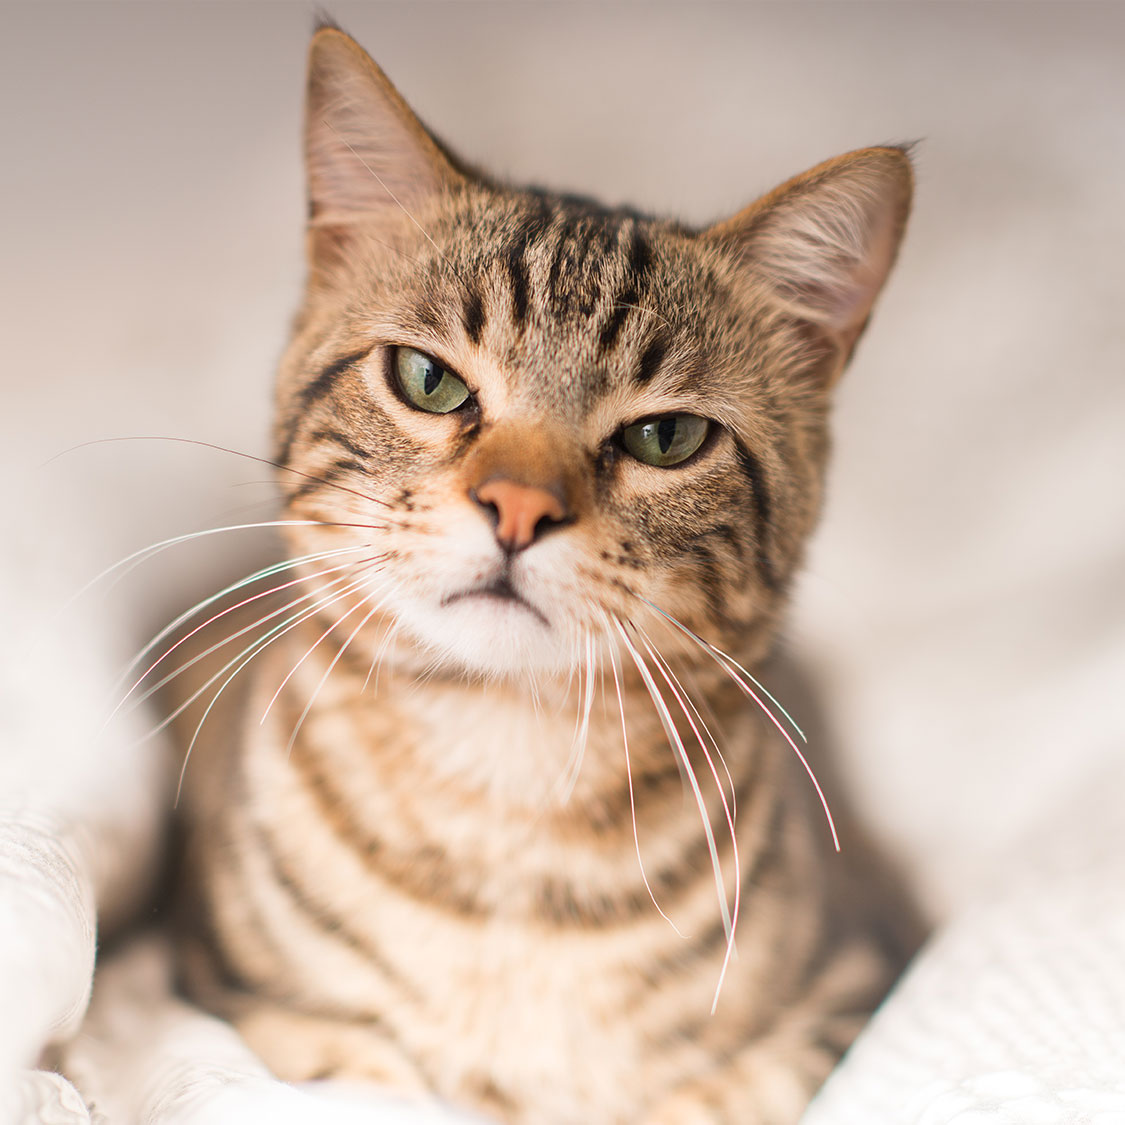

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
import numpy as np
# PIL설치는 pip install pillow

# raw_data = pd.read_csv("./dataset/sign_mnist_train.csv")
# img = raw_data.drop(labels=['label'],axis=1)
# img = img.values.reshape(-1,1,28,28)[2]

# plt.imshow(img[0], cmap='gray')
# plt.axis('off')
# plt.show()


path = 'https://s3.ap-northeast-2.amazonaws.com/elasticbeanstalk-ap-northeast-2-176213403491/media/magazine_img/magazine_327/7ae22985-90e8-44c3-a1d6-ee470ddc9073.jpg'
# path = 'https://cdn.emetro.co.kr/data2/content/image/2023/06/15/.cache/512/20230615500274.jpg'
response = requests.get(path) # 웹에서 이미지 가져오기

image_data = response.content  # 바이너리 데이터로 읽음
img = Image.open(BytesIO(image_data)) # 바이너리 데이터를 이미지로 변환

# img = Image.open(BytesIO(response.content)) 이렇게 바로 작성해도 됨

img.show()

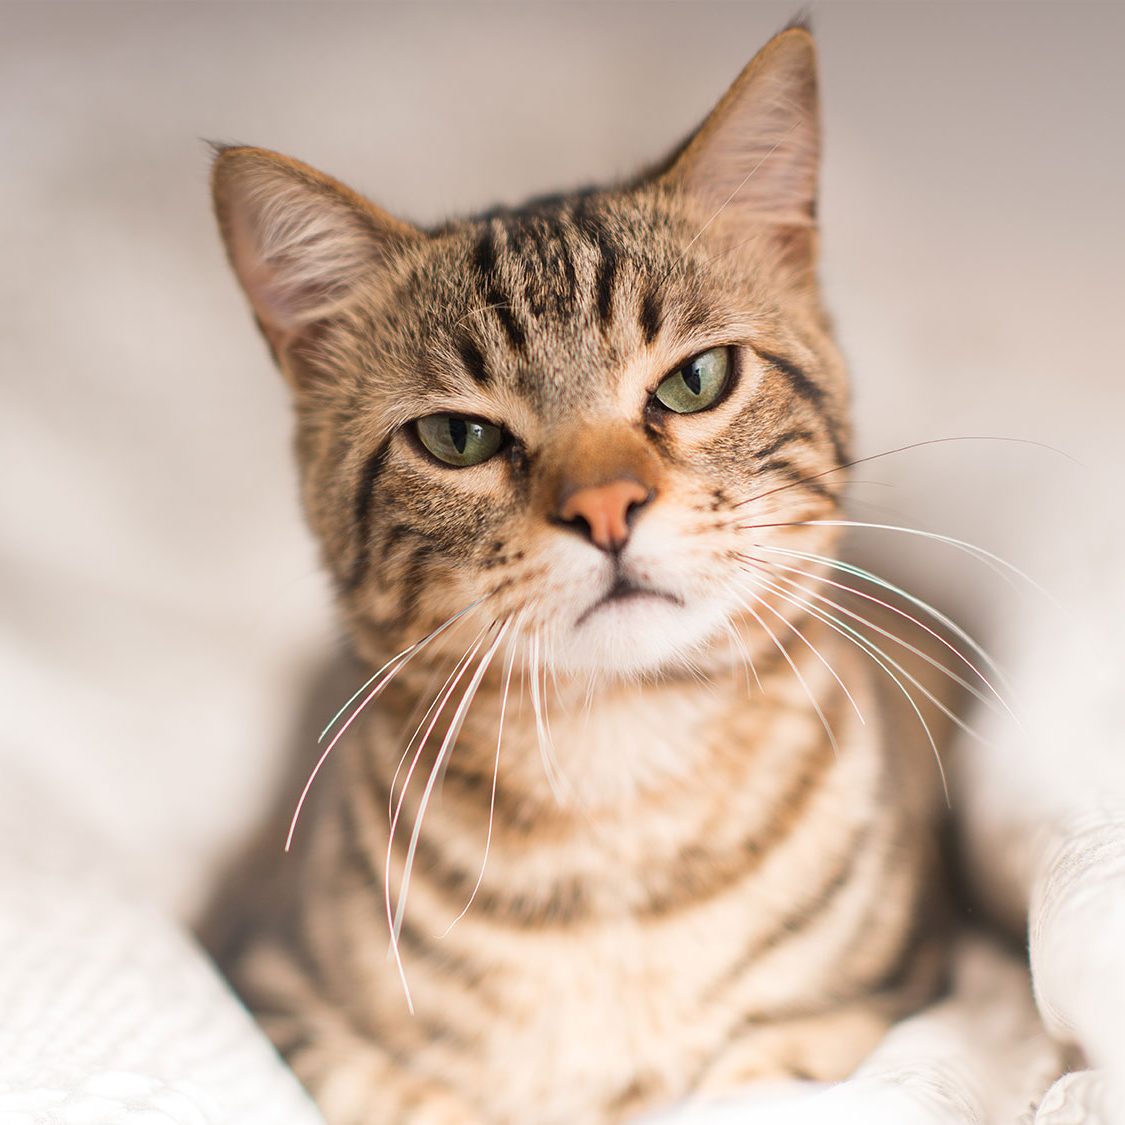

In [284]:
import albumentations as A

# 지금 img는 PIL 형식이다.

img = np.array(img) # Albumentations는 numpy로 입력을 받아야한다.

# 여러가지 augmentation 적용
transforms = A.Compose([
                A.OneOf([A.Rotate(50,always_apply=True),
                          A.HorizontalFlip(always_apply=True)],
                          p=0.5),
                A.OneOf([A.AdvancedBlur(blur_limit=(3, 7), sigma_x_limit=(0.2, 1.0), sigma_y_limit=(0.2, 1.0),always_apply=False),
                         A.GlassBlur(sigma=0.7, max_delta=4,p=0.5),
                         A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=True)
                         ]),
                A.OneOf([A.CropAndPad(px=150,keep_size=True,p=0.5),
                         A.GridDropout(ratio=0.5,p=0.5),
                         A.CoarseDropout(max_holes = 40 , 
                                        max_height = 80 , 
                                        max_width = 20 , 
                                        min_holes = 20,
                                        fill_value = (255,0,0),
                                        always_apply=True)
                         ]),
                A.OneOf([A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8),p=0.5),
                         A.ColorJitter(brightness=(0.8, 1), 
                                       contrast=(0.8, 1), 
                                       saturation=(0.8, 1), 
                                       hue=0.1,p=0.5)
                         ]),
                A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1,0.1))
                # ToTensorV2() # numpy로 입력받아 변형하고 tensor로 반환하기 위해 마지막에 Totensor를 넣어주는 것을 권장한다.
                ])

# 한 가지 augmentation으로 이미지 변환 정도 확인
# transforms = A.Compose([A.ElasticTransform(alpha=1, 
#                                            sigma=50, 
#                                            alpha_affine=50, 
#                                            interpolation=1, 
#                                            border_mode=4,
#                                            always_apply=True)
#                 ])


# transforms = A.ColorJitter(brightness=0.4, 
#                             contrast=(0.4, 1.5), 
#                            saturation=(0.8, 1), 
#                            hue=0,
#                             p=0.5)

# transforms = A.Compose([A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8))
#                 ])

# 아마 cutout은 albumentations 최신버전에서는 없어진 듯..??
# transforms = A.Cutout(num_holes = 4, 
#                         max_h_size = 3, 
#                         max_w_size = 3, 
#                         fill_value = (255,255,0),
#                         always_apply=True)  

# cutout은 정사각형만 구멍 내지만 CoarseDropout은 직사각형 구멍 가능
# transforms = A.CoarseDropout(
#                     max_holes = 40 , 
#                     max_height = 12 , 
#                     max_width = 4 , 
#                     min_holes = 10,
#                     fill_value = (255,0,0),
#                     always_apply=True)    

transformed_img = transforms(image=img)['image'] # 변형된 numpy 이미지

transformed_pil_img = Image.fromarray(transformed_img) # PIL 형식으로 변형해준다.

transformed_pil_img.show()

In [282]:
# (255, 0, 0),      # 빨강
# (0, 255, 0),      # 초록
# (0, 0, 255),      # 파랑
# (255, 255, 0),    # 노랑
# (255, 0, 255),    # 보라
# (0, 255, 255),    # 시안
# (255, 255, 255),  # 흰색
# (128, 128, 128),  # 회색
# (0, 128, 128),    # 짙은 시안
# (128, 0, 128),    # 자홍
# (0, 100, 0),      # 어두운 초록
# (255, 165, 0),    # 오렌지
# (100, 100, 100),  # 짙은 회색
# (255, 192, 203),  # 분홍
# (128, 0, 0),      # 짙은 빨강
# (0, 128, 0),      # 어두운 초록
# (139, 0, 0),      # 어두운 빨강
# (0, 0, 128),      # 짙은 파랑
# (0, 0, 0),        # 검정
# (210, 105, 30),   # 초콜릿
# (244, 164, 96),   # 살구색
# (128, 128, 0),    # 올리브
# (255, 69, 0),     # 빨간 주황
# (169, 169, 169),  # 어두운 회색
# (128, 128, 255),  # 하늘색
# (70, 130, 180)    # 스카이 블루